In [11]:
# Definindo espaço de estados
A = np.array([0.9])
B = np.array([0.1])
C = np.array([1.0])
D = np.array([0.0])


def model(x: np.ndarray, u: np.ndarray):
    x = A * x + B * u
    y = C * x + D * u
    return y


def model_ss(x: np.ndarray, u: np.ndarray):
    x = A * x + B * u
    y = C * x + D * u
    return y


def y_to_x(y):
    x = y  # Sistema diretamente observável
    return x


In [12]:
from scipy.optimize import minimize

Np = 10  # horizonte de predição
Nc = 2  # horizonte de controle
Q = 1.0  # peso no erro
R = 0.01  # peso na variação da entrada


def J(u_seq, x0, sp, u0):
    """
    u_seq: sequência de entradas (Nc,)
    x0: estado atual
    sp: setpoint
    u0: última entrada aplicada
    """
    x = x0
    cost = 0.0

    for k in range(Np):
        # Usa a última entrada se k >= Nc
        if k < Nc:
            u = u_seq[k]
        else:
            u = u_seq[-1]

        y = model_ss(x, u)
        cost += Q * (y - sp) ** 2
        x = y_to_x(y)

    u_old = u0
    for k in range(Nc):
        u = u_seq[k]
        cost += R * (u - u_old) ** 2
        u_old = u

    return cost


def MPC(x0, sp, u_old):
    """
    x0: estado atual
    sp: setpoint
    u_old: última entrada aplicada
    """
    u0 = np.full(Nc, u_old)

    # Otimização
    res = minimize(J, u0, args=(x0, sp, u_old), method="SLSQP")

    # Retorna a primeira entrada da sequência otimizada
    return res.x[0]


In [13]:
cycles = 20

# Prealocando histórico de saída e entrada
y = np.zeros(cycles)
y[0] = 0
u = np.zeros(cycles)
u[0] = 0

sp = 2.0  # setpoint

x = y_to_x(y[0])
for k in range(1, cycles):
    u[k] = MPC(x, sp, u[k - 1])

    # Atualiza o estado
    y[k] = model(y[k - 1], u[k]).item()
    x = y_to_x(y[k])


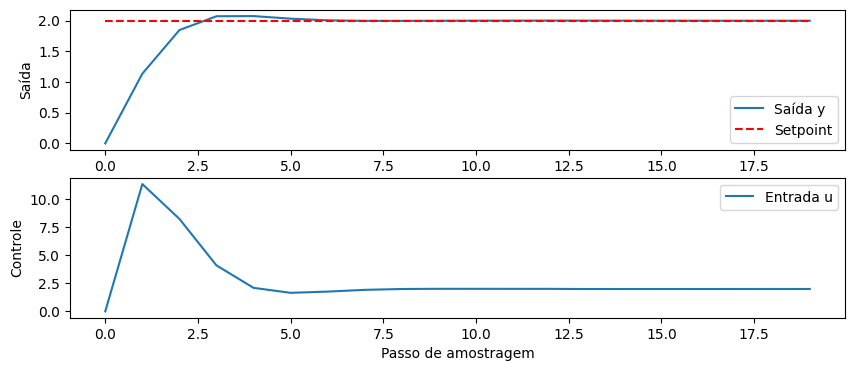

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(y, label="Saída y")
plt.plot([sp] * len(y), "r--", label="Setpoint")
plt.ylabel("Saída")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(u, label="Entrada u")
plt.ylabel("Controle")
plt.xlabel("Passo de amostragem")
plt.legend()
plt.show()
